# Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is one of the most convenient neural network environments when the work involves defining new layers. 

This homework requires sending **multiple** files, please do not forget to include all the files when submit. The list of files:
- This notebook
- assignment1_modules.ipynb
- assignment0_differentiation.ipynb

You should submit it by **GitHub**

In [ ]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

"""
--------------------------------------
-- Tech note
--------------------------------------    
np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
for better memory handling

Suppose you allocated a variable    

    a = np.zeros(...)

So, instead of

    a = b + c  # will be reallocated, GC needed to free

I would go for: 

    np.add(b,c,out = a) # puts result in `a`

But it is completely up to you.
"""

In [2]:
# Note that every time you change assignment1_modules.ipynb, 
# you should run this cell to apply your changes
%run assignment1_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        Make this function faster if you can!
        
        Try to understand this code to be able to implement Adam
        below, as the implementation is very similar
        
        x: list of lists
            - parameters
        dx: list of lists
            - gradients of parameters,
              same format as x above
        config: dict
            - momentum
            - learning_rate
        state: dict
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})

    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            cur_old_grad = config['momentum'] * cur_old_grad + config['learning_rate'] * cur_dx
            
            state['old_grad'][i] = cur_old_grad
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            np.add(cur_x, -cur_old_grad, out=cur_x, dtype=np.float32)
            i += 1


In [4]:
def adam_optimizer(x, dx, config, state):
    """ 
        config:
            - b1, 
            - b2,
            - alpha
        state:
            - old_grad
    """
    state.setdefault('m', {})
    state.setdefault('v', {})
    i = 0
    for cur_layer_x, cur_layer_dx in zip(x,dx):
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            m = state['m'].setdefault(i, np.zeros_like(cur_dx))
            v = state['v'].setdefault(i, np.zeros_like(cur_dx))
            
            m = config['b1'] * m + (1 - config['b1']) * cur_dx
            v = config['b2'] * v + (1 - config['b2']) * cur_dx**2
            
            state['m'][i] = m
            state['v'][i] = v
            
            m_hat = m/(1-(config['b1']*(config['b1']**i)))
            v_hat = v/(1-(config['b2']*(config['b2']**i)))
            if m.shape[0] == 1:
                cur_x = cur_x.reshape(m.shape)
            np.add(cur_x, -config['alpha'] * m_hat / (v_hat**0.5 + config['alpha']), out=cur_x,  dtype=np.float32)
            i += 1

Implement [**Adam optimizer**](https://arxiv.org/abs/1412.6980). Test and experiment it. Write your opinion.


Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none');

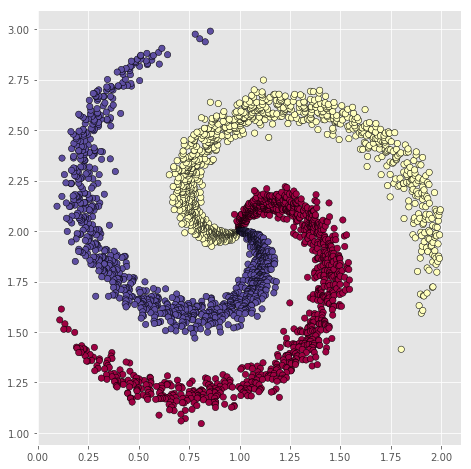

In [5]:
########################
# MORE COMPLEX 2D DATA #
########################

N = 1000 # number of points per class
D = 2 # dimensionality
p = 4 # polynomial degree
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
X[:, 0] += 1
X[:, 1] += 2
# lets visualize the data:
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors="black")
ax = plt.gca()
ax.set_aspect("equal")
plt.show()
import pandas as pd
Y = np.array(pd.get_dummies(y)).astype(int)

Define a **logistic regression** for debugging. 

In [6]:
# Note that every time you change assignment1_modules.ipynb, 
# you should run this cell to apply your changes
%run assignment1_modules.ipynb

In [7]:
criterion = CrossEntropyCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2,15))
net.add(BatchMeanSubtraction())
net.add(SoftPlus())
net.add(Linear(15,40))
net.add(BatchMeanSubtraction())
net.add(ELU())
net.add(Linear(40, 3))
net.add(SoftMax())
print(net)

Linear 2 -> 15
BatchMeanNormalization
SoftPlus
Linear 15 -> 40
BatchMeanNormalization
ELU
Linear 40 -> 3
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [8]:
# Optimizer params for Adam
optimizer_config = {'alpha' : 8e-3, 'b1': 0.9, 'b2': 0.99, 'epsilon': 1e-8}
optimizer_state = {}

# Looping params
n_epoch = 500
batch_size = 1000

In [9]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

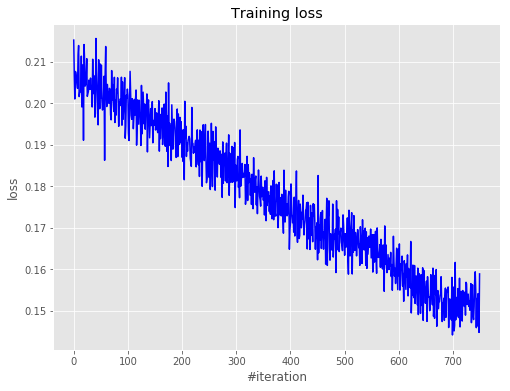

Current loss: 0.158852


In [13]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X, Y, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)       
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

Now visualise class boundaries

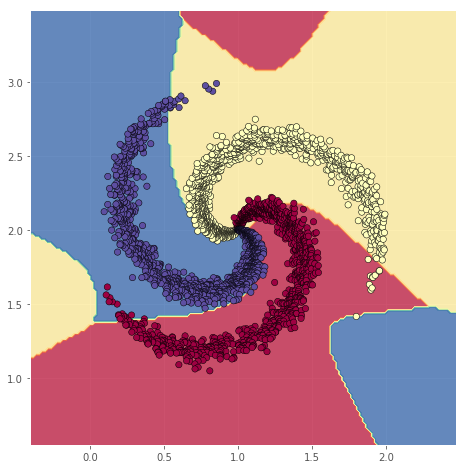

In [15]:
h = 0.02

x_min = X[:, 0].min() - 0.5
x_max =  X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
X0, Y0 = np.meshgrid(np.arange(x_min, x_max, h),
                 np.arange(y_min, y_max, h))

X0flat = X0.reshape(-1)
Y0flat = Y0.flatten()

X1 = np.stack([X0flat, Y0flat]).T

c = np.argmax(net.forward(X1), axis=-1).reshape(X0.shape)

c.shape

plt.figure(figsize=(10,8))
plt.contourf(X0, Y0, c, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=Y.argmax(axis=-1), s=40, cmap=plt.cm.Spectral, edgecolors="black")
plt.xlim(X0.min(), X0.max())
plt.ylim(Y0.min(), Y0.max())
plt.gca().set_aspect("equal")
plt.show()

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [18]:
import os
from sklearn.datasets import fetch_openml
allow_pickle=True

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r', allow_pickle=True) as d:
        data = np.hstack((d['X'],d['y'][np.newaxis].T))        
else:
    mnist = fetch_openml('mnist_784')
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

In [19]:
np.random.shuffle(data)
X = np.array(data[:,:-1], dtype=np.float32)
Y = np.array(data[:,-1:], dtype=np.float32)

One-hot encode the labels first.

In [20]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
one_hot_y = np.array(enc.fit_transform(Y.reshape(-1, 1)).todense())

/home/nitrov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [21]:
x_train = X[:18400]
y_train = one_hot_y[:18400]
x_test= X[18400:20400]
y_test = one_hot_y[18400:20400]

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchMeanSubtraction` between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchMeanSubtraction` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

Write your personal opinion on the activation functions, think about computation times too. Does `BatchMeanSubtraction` help?

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

In [22]:
criterion = CrossEntropyCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(784,1000))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(1000,1500))
net.add(Dropout())
net.add(ReLU())
net.add(Linear(1500,10))
net.add(SoftMax())
print(net)

Linear 784 -> 1000
BatchMeanNormalization
ReLU
Linear 1000 -> 1500
Dropout
ReLU
Linear 1500 -> 10
SoftMax



In [36]:
#Optimizer params for Adam
optimizer_config = {'alpha' : 5e-3, 'b1': 0.9, 'b2': 0.999, 'epsilon': 1e-8}
optimizer_state = {}

In [38]:
#optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
#optimizer_state = {}

# Looping params
n_epoch = 200
batch_size = 128

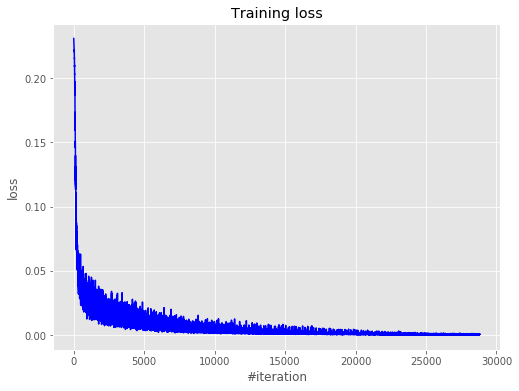

Current loss: 0.001099


In [39]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(x_train, y_train, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        if i >= 169:
            optimizer_config['alpha'] = 1.5e-3
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)       
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

In [40]:
net.evaluate()
predicted = net.forward(x_test)
predicted = np.argmax(predicted, axis=1)

Print here your accuracy. It should be around 90%.

In [41]:
from sklearn.metrics import accuracy_score
print("The Accuracy is", accuracy_score(predicted, np.argmax(y_test, axis=1))*100,"%")

The Accuracy is 96.8 %


# Autoencoder (optional) 

This part is **OPTIONAL**, you may not do it, but it is easy and extremely interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
![](img/autoencoder.png)

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction. Use **BatchMeanNormalization** between **Linear** and **ReLU**. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [77]:
criterion = MSECriterion()

net = Sequential()
net.add(Linear(784,512))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(512,256))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(256,128))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(128,30))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(30,128))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(128,256))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(256,512))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(512,784))
print(net)

#Optimizer params for Adam
optimizer_config = {'alpha' : 1.2e-3, 'b1': 0.9, 'b2': 0.9999, 'epsilon': 1e-8}
optimizer_state = {}

loss_history = []

Linear 784 -> 512
BatchMeanNormalization
ReLU
Linear 512 -> 256
BatchMeanNormalization
ReLU
Linear 256 -> 128
BatchMeanNormalization
ReLU
Linear 128 -> 30
BatchMeanNormalization
ReLU
Linear 30 -> 128
BatchMeanNormalization
ReLU
Linear 128 -> 256
BatchMeanNormalization
ReLU
Linear 256 -> 512
BatchMeanNormalization
ReLU
Linear 512 -> 784



In [92]:
# Looping params
n_epoch = 6
batch_size = 256

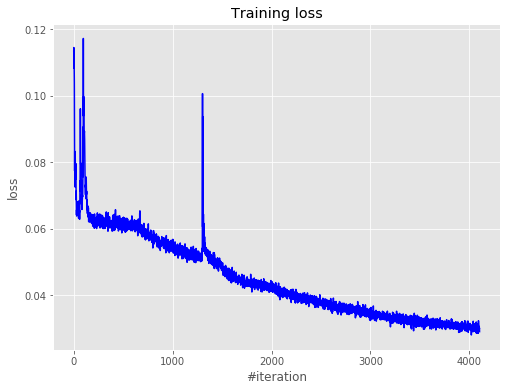

Current loss: 0.029027


In [107]:
for i in range(n_epoch):
    for x_batch, y_batch in get_batches(x_train, x_train, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        if i%3 == 0 :
            optimizer_config = {'alpha' : 1.2e-3 - i*10**(-4), 'b1': 0.9, 'b2': 0.9999, 'epsilon': 1e-8}
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)  
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

In [108]:
net.evaluate()
predicted = net.forward(x_test)

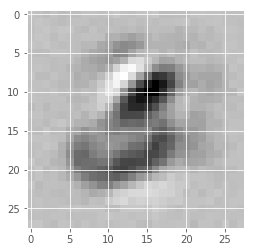

The label is 5


In [109]:
plt.imshow(predicted[13].reshape((28, 28)), cmap="gray_r")
plt.show()
print("The label is", np.argmax(y_test[13]))

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [110]:
net.remove(net[21])
net.remove(net[20])
net.remove(net[19])
net.remove(net[18])
net.remove(net[17])
net.remove(net[16])
net.remove(net[15])
net.remove(net[14])
net.remove(net[13])
net.remove(net[12])
net.remove(net[11])
net.remove(net[10])

print(net)

Linear 784 -> 512
BatchMeanNormalization
ReLU
Linear 512 -> 256
BatchMeanNormalization
ReLU
Linear 256 -> 128
BatchMeanNormalization
ReLU
Linear 128 -> 30



In [111]:
net.add(BatchMeanSubtraction())
net.add(ELU())
net.add(Linear(30,10))
net.add(SoftMax())

In [112]:
print(net)

Linear 784 -> 512
BatchMeanNormalization
ReLU
Linear 512 -> 256
BatchMeanNormalization
ReLU
Linear 256 -> 128
BatchMeanNormalization
ReLU
Linear 128 -> 30
BatchMeanNormalization
ELU
Linear 30 -> 10
SoftMax



In [113]:
#Optimizer params for Adam
optimizer_config = {'alpha' : 1e-3, 'b1': 0.9, 'b2': 0.999, 'epsilon': 1e-8}
optimizer_state = {}

# Looping params
n_epoch = 4
batch_size = 256

loss_history = []

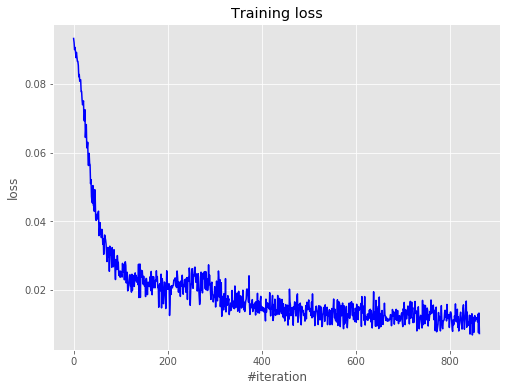

Current loss: 0.007269


In [120]:
for i in range(n_epoch):
    for x_batch, y_batch in get_batches(x_train, y_train, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        if i%3 == 0 :
            optimizer_config = {'alpha' : 1e-3- i*10**(-4), 'b1': 0.9, 'b2': 0.999, 'epsilon': 1e-8}
        
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)  
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

In [121]:
net.evaluate()
predicted = net.forward(x_test)
predicted = np.argmax(predicted, axis=1)
from sklearn.metrics import accuracy_score
print("The Accuracy is", accuracy_score(predicted, np.argmax(y_test, axis=1))*100,"%")

The Accuracy is 91.35 %


The Model is rather undertrained, still performed quite well for the amount trained 

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [118]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
pca_test = pca.fit_transform(x_test)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(predicted[5].reshape((28, 28)), cmap="gray_r")
plt.show()
print("Result with Auto-Encoder", np.argmax(y_test[5]))
plt.subplot(1,2,2)
plt.imshow(pca_test[5].reshape((8, 8)), cmap="gray_r")
plt.show()
print("The label is", np.argmax(y_test[5]))

# Experiments (interesting) 

* Use ANN with one hidden layer for simple 1d regression problem (generate random points and fit your model on it).
Compare **Tanh** and **ReLu** activations for hidden layer (note that you do not need any nonlinearity for output layer). Also tweak hidden layer size.

In [ ]:
#somewhat implemented above

* Train a multilayer model on MNIST and reach ~95% accuracy on test set. Now randomly remove neurons from your network (i.e. set neuron parameters zero). Plot test set accuracy versus number of neurons removed. Do the same expeiment with 1) Dropout layer added, 2) BatchMeanSubtraction layer added.

In [ ]:
#somewhat implemented above

* Train a model on MNIST with multiclass criterion. Now backpropagate label throw network, i.e. find the input that would produce given output. Your label was one-hot-encoded (only one digit was on the picture). This time backpropagate label, which has 2 or more ones and see the input picture of the network.